# Identifying Factors that Affect Mental Health Issues in the Philippines

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
from collections import Counter
from operator import itemgetter
import praw #Python library for scraping Reddit
from gensim.summarization import keywords
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim import corpora
import ast
from gensim.summarization import keywords

### Data Scraping

The scraping is done using the PRAW API.

For security purposes, the API keys won't be shared here. Procedure can easily be searched in the web. 

In [102]:
client_id = ''  # Insert client id here
secret_key = ''  # Insert secret key here
agent = ''  # Insert user agent here

reddit = praw.Reddit(client_id=client_id,
                     client_secret=secret_key,
                     user_agent=agent)

Scraping the r/mentalhealthph subreddit. We scrape all posts.

In [4]:
subreddit = reddit.subreddit('MentalHealthPh').top('all',limit=None)

In [5]:
def get_date(created):
    """Parses timestamp input in date format."""
    return dt.datetime.fromtimestamp(created)

In [6]:
posts = pd.DataFrame(columns=['author', 'title', 'upvotes', 'id',
                              'num_comments', 'body', 'all_comments',
                              'created'])
for i, post in enumerate(subreddit):
    print(i, end='\r')
    try:
        name = post.author.name
    except:
        name = 'n/a'
    try:
        body = post.selftext
    except:
        body = 'None'
    try:
        title = post.title
    except:
        title = 'None'
    try:
        comments = [comment.body for comment in post.comments]
    except:
        comments = 'None'

    posts.loc[i] = [name, title, post.score, post.id,
                    post.num_comments, body, comments,
                    post.created]

In [7]:
posts['time_stamp'] = posts['created'].apply(get_date)

**Saving the scraped data**

We save the scraped data in csv format so we can easily access in the future. This is named `'mentalhealth_final.csv'.`

In [10]:
posts.to_csv('mentalhealth_final.csv')

### Data Preprocessing

We now clean our scraped data. 

In [2]:
mh = pd.read_csv('mentalhealth_final.csv')
mh = mh.drop('Unnamed: 0', axis=1)

In [3]:
import re
tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

stop_words = list(stopwords.words('english')) + \
['mental','cant','dont','wont',
 'please','help','ako','na','ang','niya','ikaw','naman','siya','tayo', 'ko', 
 'like','likely', 'ba','ay','rmentalhealthph','weekly','discussion','daw','im',
'ive','id','anyone','youre','theyre','sa','nang','lang','at','yung','kasi',
'pm','ur','hindi','di','pa','iyan','iyon','pero','talaga']

def preprocess(text):
    # Convert to lower case
    text = text.lower()

    # Remove punctuations and special characters
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove english stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])   
    
    # Perform Tokenization and lemmatization
    text = [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)]
    return text


mh['title'] = mh['title'].apply(preprocess)
mh['body'] = mh['body'].astype(str).apply(preprocess)

In [4]:
mh = mh.dropna()

In [6]:
mh.head(5)

,author,title,upvotes,id,num_comments,body,all_comments,created,time_stamp,year,month,day
0,Unsatiability,[frustrated],2,jnu5ln,1,"[background, 21m, currently, college, kept, tr...",['Thank you for posting in r/MentalHealthPH. P...,1.604513e+09,2020-11-05 02:03:45,2020,11,5
1,Infamous_Option,"[adhd, discord, support, group]",1,jnt743,1,"[hi, dm, interested, joining, discord, server,...",['Thank you for posting in r/MentalHealthPH. P...,1.604508e+09,2020-11-05 00:33:43,2020,11,5
2,okayerinasai24,"[indiescord, discover, new, song, meet, new, f...",16,jnt096,1,"[henlo, feeling, bit, blue, gusto, nyo, makini...",['Thank you for posting in r/MentalHealthPH. P...,1.604507e+09,2020-11-05 00:16:17,2020,11,5
3,Seantheocean,"[support, group, adhd, discord, open, also, lo...",3,jnstue,1,"[interested, mod, hello, created, discord, ser...",['Thank you for posting in r/MentalHealthPH. P...,1.604506e+09,2020-11-05 00:00:44,2020,11,5
4,MinuteAvocado,"[sick, tired, parent, internalized, misogyny, ...",34,jn886f,3,"[often, case, daughter, given, responsibility,...",['Thank you for posting in r/MentalHealthPH. P...,1.604429e+09,2020-11-04 02:49:28,2020,11,4


### Document term Matrix

Before we do topic modeling, we convert our corpus to a document term matrix using bag of words.

In [7]:
import gensim
from gensim import corpora, models

dictionary = corpora.Dictionary(mh['title'])
dictionary.filter_extremes(no_below=22)
doc_mat = [dictionary.doc2bow(text)
                 for text in mh['title']]

### Topic Modeling via LDA

We now perform topic modeling. We identify the optimal number of topics using c_v topic coherence.

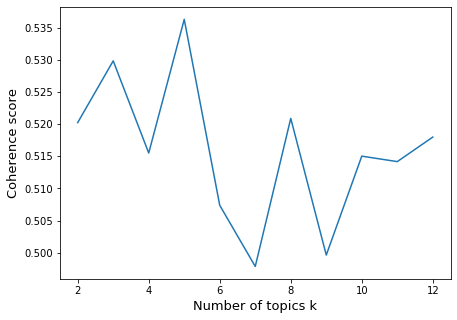

In [24]:
from gensim.models import CoherenceModel

def find_k(corpus, dictionary, topics):
    score = []
    for k in range(2, topics+1):
        LDA = gensim.models.ldamodel.LdaModel
        ldamodel = LDA(corpus, num_topics=k, 
                       id2word = dictionary,random_state=1,
                       passes=15)
    
        coherence = CoherenceModel(model=ldamodel, 
                                   texts=mh['title'], 
                                   dictionary=dictionary, 
                                   coherence='c_v')
        score.append(coherence.get_coherence())
    fig = plt.figure(figsize=(7,5))
    plt.plot(np.arange(2,topics+1),score)
#     plt.title("Coherence score for varying k")
    plt.xlabel("Number of topics k",fontsize=13)
    plt.ylabel("Coherence score",fontsize=13)
    

find_k(doc_mat, dictionary, 12)

In [8]:
LDA = gensim.models.ldamodel.LdaModel
ldamodel = LDA(doc_mat, num_topics=5,id2word = dictionary, random_state=1,
               passes=10)

# ldamodel.print_topics()
ldamodel.print_topics(num_words=4)

[(0,
  '0.119*"adhd" + 0.118*"psychologist" + 0.115*"looking" + 0.076*"psychiatrist"'),
 (1, '0.237*"need" + 0.169*"feel" + 0.131*"psychiatrist" + 0.117*"friend"'),
 (2,
  '0.134*"life" + 0.103*"therapist" + 0.097*"disorder" + 0.085*"depression"'),
 (3,
  '0.245*"health" + 0.164*"consultation" + 0.154*"online" + 0.118*"therapy"'),
 (4, '0.227*"anxiety" + 0.160*"support" + 0.131*"group" + 0.124*"thinking"')]

In [9]:
for i, topic in enumerate(ldamodel.show_topics(num_words=5)):
    print(f"Topic {i}: {topic[1]}")

Topic 0: 0.119*"adhd" + 0.118*"psychologist" + 0.115*"looking" + 0.076*"psychiatrist" + 0.069*"want"
Topic 1: 0.237*"need" + 0.169*"feel" + 0.131*"psychiatrist" + 0.117*"friend" + 0.093*"know"
Topic 2: 0.134*"life" + 0.103*"therapist" + 0.097*"disorder" + 0.085*"depression" + 0.079*"parent"
Topic 3: 0.245*"health" + 0.164*"consultation" + 0.154*"online" + 0.118*"therapy" + 0.097*"first"
Topic 4: 0.227*"anxiety" + 0.160*"support" + 0.131*"group" + 0.124*"thinking" + 0.062*"think"


### Assign topics to documents and Get Distribution of Topics

In [10]:
topic_dist = ldamodel.get_document_topics(doc_mat)
topics = [sorted(topic_dist[i],key=lambda x: -x[1])[0][0] 
          for i in range(len(mh))]
mh['topics'] = topics

In [11]:
topic_doc = mh['topics'].value_counts().sort_index()

In [12]:
topic_doc.index = ['ADHD', 'Seek Help', 'Depression', 'Online Therapy', 'Anxiety']

Text(0, 0.5, 'Document Count')

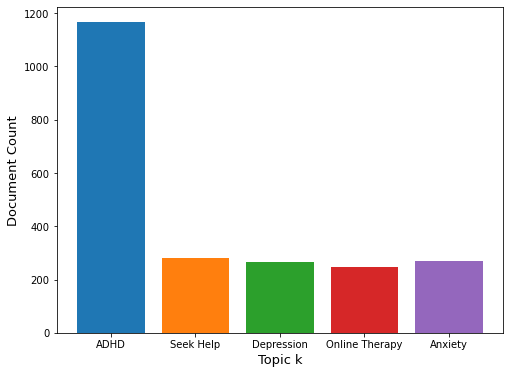

In [13]:
# plt.title("Distribution of Documents belonging to a Topic")
fig = plt.figure(figsize=(8,6))


plt.bar(topic_doc.index[0], topic_doc.values[0])
plt.bar(topic_doc.index[1], topic_doc.values[1])
plt.bar(topic_doc.index[2], topic_doc.values[2])
plt.bar(topic_doc.index[3], topic_doc.values[3])
plt.bar(topic_doc.index[4], topic_doc.values[4])

plt.xlabel("Topic k",fontsize=13)
plt.ylabel("Document Count",fontsize=13)

### Identifying time series trends in the number of posts per topics.

In [14]:
def grouper(df, topics):
    """Groups by month, year and calculates monthly distribution of topics."""
    df['date'] = df['month'].map(str) + '-' + df['year'].map(str)
    df['date'] = pd.to_datetime(
        df['date'], format='%m-%Y').dt.strftime('%m-%Y')
    df = pd.DataFrame(df.groupby('date')['topics'].value_counts())
    df = df[df.index.isin([topics], level=1)]
    df.index = df.index.set_levels(pd.to_datetime(df.index.levels[0]), level=0)
    df = df.sort_index(level='date')
    dates = [d[0] for d in df.index]
    return dates, df['topics'].values

In [15]:
t0_date, t0_val = grouper(mh,0)
t1_date, t1_val = grouper(mh,1)
t2_date, t2_val = grouper(mh,2)
t3_date, t3_val = grouper(mh,3)
t4_date, t4_val = grouper(mh,4)

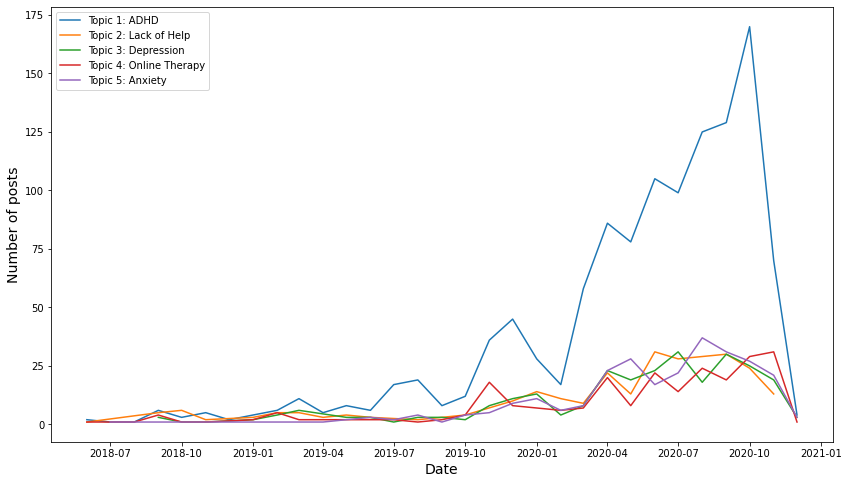

In [16]:
fig = plt.figure(figsize=(14,8))

plt.plot_date(t0_date,t0_val, '-',label='Topic 1: ADHD')
plt.plot_date(t1_date,t1_val,'-',label='Topic 2: Lack of Help')
plt.plot_date(t2_date,t2_val,'-',label='Topic 3: Depression')
plt.plot_date(t3_date,t3_val,'-',label='Topic 4: Online Therapy')
plt.plot_date(t4_date,t4_val,'-',label='Topic 5: Anxiety')
plt.xlabel("Date",fontsize=14)
plt.ylabel("Number of posts",fontsize=14)
plt.legend()

One interesting insights is the large spikes in ADHD related posts during the month of October. The likely reason is that October is the ADHD Awareness month. We also see a drastic increase in the beginning of the lockdown.

### Keyword Extraction with TextRank Algorithm

We now perform keyword extraction per topic using TextRank. This easily done using gensim.

In [17]:
from gensim.summarization import keywords

In [18]:
def filter_topic(data,topic,col):
    """Filters data by topic."""
    return data.query(f'topics=={topic}')[col]

In [19]:
#All posts belonging to a topic are segmented using filter_topic function.
adhd = ' '.join(filter_topic(mh,0,'body').apply(lambda x: ' '.join(x)))
seek_help = ' '.join(filter_topic(mh,1,'body').apply(lambda x: ' '.join(x)))
depression = ' '.join(filter_topic(mh,2,'body').apply(lambda x: ' '.join(x)))
online = ' '.join(filter_topic(mh,3,'body').apply(lambda x: ' '.join(x)))
anxiety = ' '.join(filter_topic(mh,4,'body').apply(lambda x: ' '.join(x)))

Since we are extracting factors or triggers of mental health issue, we filter words that are noun for our text rank key word extraction. This is so to reduce noise in our results.

In [20]:
def pos(text):
    """Removes words that are not nouns."""
    stop_words = stopper()
    text = tokenizer.tokenize(text)
    text = nltk.pos_tag(text)
    text = [i[0] for i in text if i[1].startswith('N')]
    text = [lemmatizer.lemmatize(i) for i in text]
    text = [i for i in text if i not in stop_words]

    return ' '.join(text)

In [46]:
def stopper():
    """Stopwords."""
    stopwords_filipino = list(pd.read_csv('stopwords_tagalog.txt', header=None)[0])
    additional_words = ["ain't", "amn't", "aren't", "can't", "could've", "couldn't",
                    "daresn't", "didn't", "doesn't", "don't", "gonna", "gotta",
                    "hadn't", "hasn't", "haven't", "he'd", "he'll", "he's", "how'd",
                    "how'll", "how's", "I'd", "I'll", "I'm", "I've", "isn't", "it'd",
                    "it'll", "it's", "let's", "mayn't", "may've", "mightn't",
                    "might've", "mustn't", "must've", "needn't", "o'clock", "ol'",
                    "oughtn't", "shan't", "she'd", "she'll", "she's", "should've",
                    "shouldn't", "somebody's", "someone's", "something's", "that'll",
                    "that're", "that's", "that'd", "there'd", "there're", "there's",
                    "these're", "they'd", "they'll", "they're", "they've", "this's",
                    "those're", "tis", "twas", "twasn't", "wasn't", "we'd", "we'd've",
                    "we'll", "we're", "we've", "weren't", "what'd", "what'll",
                    "what're", "what's", "what've", "when's", "where'd", "where're",
                    "where's", "where've", "which's", "who'd", "who'd've", "who'll",
                    "who're", "who's", "who've", "why'd", "why're", "why's", "won't",
                    "would've", "wouldn't", "y'all", "you'd", "you'll", "you're",
                    "you've", "'s", "s", "said", "also", "would",'im','ur','youre',
                    'dont','wont','cant', 'mga', 'thing','timing', 
                    'everything','something','feeling','thinking','wala',
                    'meron', 'year','month','day', 'mental','weekly',
                    'rmentalhealthph','discussion', 'week','new','thank',
                    'recommend','consult', 'ask','asks','feel','depress',
                    'akong','din','baka' 'mag','depresses','nila',
                    'thanks','mga','para','kong', 'depressive','remind',
                    'suffer','minsan','diagnos', 'didnt','time','working',
                    'parang','doesnt','thats','whats', 'baka']

    stop_words = list(stopwords.words('english')) + \
    stopwords_filipino + additional_words
    return stop_words

In [44]:
adhd_keywords = keywords(pos(adhd),words=150)
help_keywords = keywords(pos(seek_help),words=150)
depression_keywords = keywords(pos(depression),words=150)
online_keywords = keywords(pos(online),words=150)
anxiety_keywords = keywords(pos(anxiety),words=150)

In [53]:
def generate_wc(text):
    """Generates word cloud representation."""
    wc = (WordCloud(background_color='black',
                              width=2500, height=1500,
                              stopwords=stopper() + ['weekly',
                    'rmentalhealthph','discussion', 'week','new','thank',
                    'recommend','consult', 'ask','asks','feel','depress',
                    'akong','din','baka', 'mag','depresses','nila',
                    'thanks','mga','para','kong', 'depressive','remind',
                    'suffer','minsan','diagnos', 'didnt', 'understand',
                    'time','working', 'parang','doesnt','thats','whats'])
          .generate(' '.join(text.split('\n'))))
    return wc

Showing the keywords extracted from Text rank.

The most important words for each topic / mental health issue is shown via word cloud.

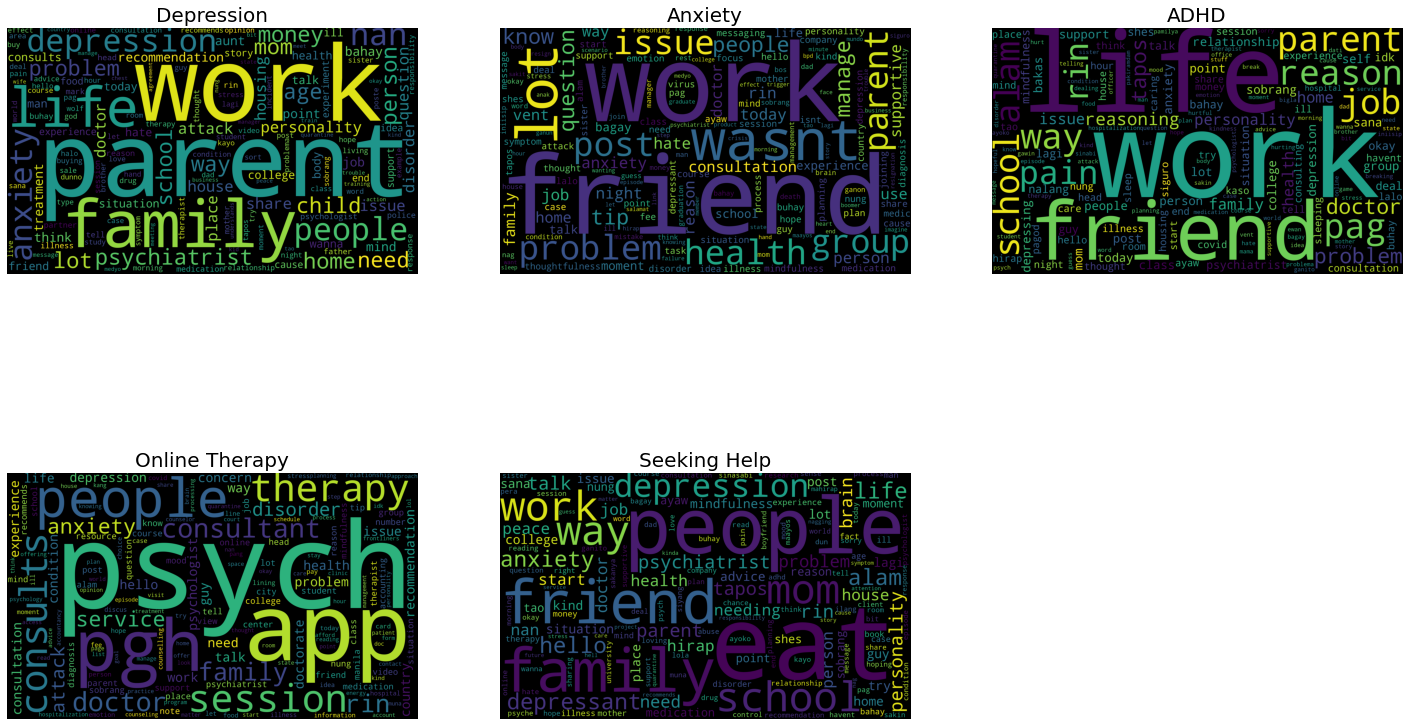

In [54]:
fig=plt.figure(figsize=(25,15))
columns = 3
rows = 2

texts = [('Depression', depression_keywords), ('Anxiety', anxiety_keywords), 
         ('ADHD', adhd_keywords), ('Online Therapy', online_keywords), 
         ('Seeking Help', help_keywords)]

for i, t in zip(range(1, 6), texts):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.title(t[0], fontsize=20)
    plt.imshow(generate_wc(t[1]))### what you want you can plot  